In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import time

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, classification_report
from torch.utils.data import DataLoader, TensorDataset

import sys
if 'helpers' in sys.modules:
    del sys.modules['helpers']
from helpers import BinaryNetwork, train_model, evaluate_model, plot_training_history, plot_evaluation_results, print_metrics, save_model_metrics

sns.set()

## Carga del Dataset

In [20]:
# Cargamos el Dataset
df = pd.read_csv("../datasets/chicago_crimes_and_stations_2024_final.csv")
test_df = pd.read_csv("../datasets/chicago_crimes_and_stations_2024_final_test.csv")


X = df.drop(["Arrest_tag"], axis=1)
y = df["Arrest_tag"]

columns = len(list(X.columns))

X_test = test_df.drop(["Arrest_tag"], axis=1)
y_test = test_df["Arrest_tag"]

X = X.values.astype(float)
y = y.values.astype(float)

X_test = X_test.values.astype(float)
y_test = y_test.values.astype(float)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y)

# Convertimos en tensores
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Creamos usando DataLoader los sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

## Inicializacion del modelo con las capas seleccionadas del experimento

In [21]:
# Inicialización del modelo, función de pérdida y optimizador
input_size = columns # número de características
layers = torch.nn.Sequential(
            torch.nn.Linear(input_size, 128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(32, 1)
        )
model = BinaryNetwork(layers)

loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

### Entrenamiento de la red neuronal

In [22]:
# Medir tiempo de entrenamiento
start_time = time.time()

history = train_model(
    model, 
    train_loader, 
    val_loader, 
    loss_fn, 
    optimizer,
    epochs=450,
    max_patience=5,
    patience_alpha=0.001,
    verbose=True,
    print_every=50  # Imprimir cada 50 épocas
)

end_train_time = time.time()
training_time = end_train_time - start_time

print(f"\n{'='*60}")
print(f"RESUMEN DEL ENTRENAMIENTO")
print(f"{'='*60}")
print(f"Épocas entrenadas: {history['epochs_trained']}")
print(f"Mejor Val Loss: {history['best_val_loss']:.4f}")
print(f"Mejor Val Accuracy: {history['best_val_acc']:.4f}")
print(f"Tiempo de entrenamiento: {training_time:.4f} s")


Época: 50/450, Train Loss: 0.5343, Val Loss: 0.5117, Val Acc: 0.7438
Época: 100/450, Train Loss: 0.4572, Val Loss: 0.4212, Val Acc: 0.7976
Early stopping en época 138

RESUMEN DEL ENTRENAMIENTO
Épocas entrenadas: 138
Mejor Val Loss: 0.4019
Mejor Val Accuracy: 0.8105
Tiempo de entrenamiento: 199.4565 s


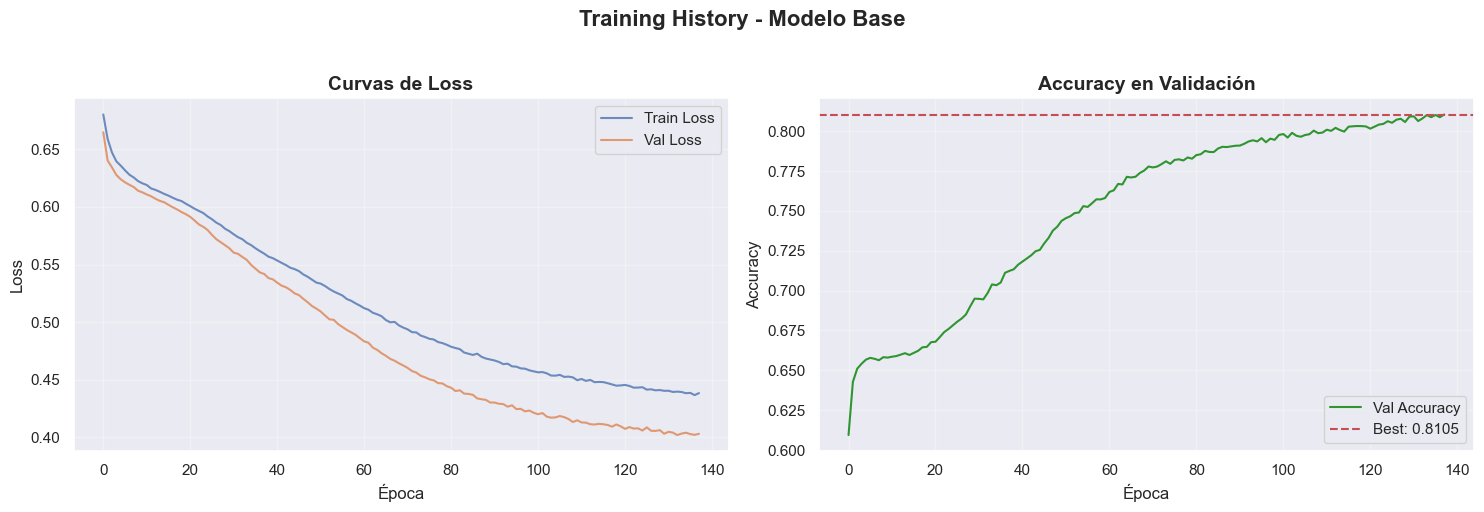

Tiempo de predicción: 0.1283 s
Tiempo total: 199.5848 s


In [23]:
# Graficar curvas de entrenamiento
plot_training_history(history, title="Training History - Modelo Base")

# Medir tiempo de predicción
start_predict_time = time.time()
predictions = evaluate_model(model, test_loader, y_test, use_sigmoid=True)
end_predict_time = time.time()
prediction_time = end_predict_time - start_predict_time

y_pred_tensor = predictions['y_pred']
y_pred_proba_tensor = predictions['y_pred_proba']

print(f"Tiempo de predicción: {prediction_time:.4f} s")
print(f"Tiempo total: {training_time + prediction_time:.4f} s")

In [24]:
# Imprimir métricas
print_metrics(y_test, y_pred_tensor, title="MÉTRICAS - MODELO BASE")

MÉTRICAS - MODELO BASE
Accuracy: 0.8194 (81.9%)
F1-score: 0.4831

              precision    recall  f1-score   support

No Arrestado       0.93      0.85      0.89     43780
   Arrestado       0.40      0.61      0.48      6964

    accuracy                           0.82     50744
   macro avg       0.67      0.73      0.69     50744
weighted avg       0.86      0.82      0.83     50744


Desglose de la Matriz de Confusión:
  Verdaderos Negativos (TN): 37,297
  Falsos Positivos (FP):     6,483
  Falsos Negativos (FN):     2,682
  Verdaderos Positivos (TP): 4,282

Métricas derivadas:
  Precisión (Precision): 0.3978
  Recall (Sensibilidad): 0.6149
  Especificidad: 0.8519


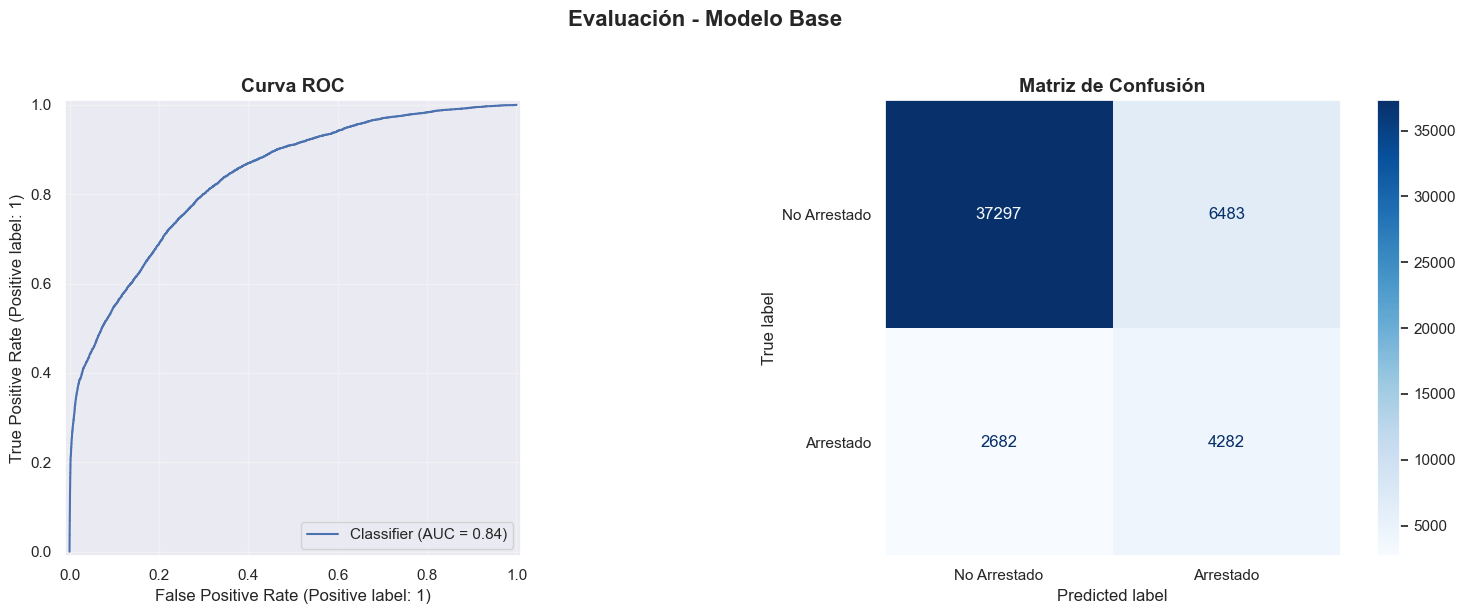

In [25]:
# Graficar ROC y Matriz de Confusión
cm = plot_evaluation_results(y_test, y_pred_tensor, y_pred_proba_tensor, 
                              title="Evaluación - Modelo Base")

In [26]:
metrics_dl_base = {
    'model_name': 'Deep Learning (Base)',
    'Accuracy': float(accuracy_score(y_test, y_pred_tensor)),
    'Precision': float(precision_score(y_test, y_pred_tensor, average='weighted')),
    'Recall': float(recall_score(y_test, y_pred_tensor, average='weighted')),
    'F1-Score': float(f1_score(y_test, y_pred_tensor, average='weighted')),
    'AUC': float(roc_auc_score(y_test, y_pred_proba_tensor)),
    'MCC score': float(matthews_corrcoef(y_test, y_pred_tensor)),
    'Entrenamiento (s)': float(training_time),
    'Predicción (s)': float(prediction_time),
    'Tiempo Total (s)': float(training_time + prediction_time)
}
save_model_metrics('Deep Learning Base', metrics_dl_base)

✓ Métricas guardadas en: ../datasets/deep_learning_base_metrics.json


## Entrenamiento del modelo con BCEWithLogitsLoss y Class Weighting
Se propone usar la funcion de loss BCEWithLogitsLoss con Class Weighting dada la cantidad de falsos negativos. Se le aporta un peso a los Arrestos para intentar mejorar las metricas.

In [27]:
print("="*70)
print("ENTRENAMIENTO CON BCEWithLogitsLoss + CLASS WEIGHTING")
print("="*70)

# Calcular peso para clase positiva
pos_weight = torch.tensor([len(y_train[y_train==0]) / len(y_train[y_train==1])])
print(f"\nPeso para clase positiva (Arrestado): {pos_weight.item():.2f}")
print(f"Esto significa que errores en 'Arrestado' pesan {pos_weight.item():.2f}x más\n")

# Definir arquitectura (igual que modelo base)
layers_weighted = torch.nn.Sequential(
    torch.nn.Linear(input_size, 128),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(128, 64),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(64, 32),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.1),
    torch.nn.Linear(32, 1)
)

# Crear modelo SIN sigmoid
model_weighted = BinaryNetwork(layers_weighted, use_sigmoid=False)
loss_fn_weighted = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer_weighted = torch.optim.Adam(model_weighted.parameters(), lr=1e-4)

# Entrenar y medir tiempo
print("Entrenando...\n")
start_time_weighted = time.time()

history_weighted = train_model(
    model_weighted, 
    train_loader, 
    val_loader, 
    loss_fn_weighted, 
    optimizer_weighted,
    epochs=450,
    max_patience=5,
    patience_alpha=0.001,
    verbose=True,
    print_every=50
)

end_train_time_weighted = time.time()
training_time_weighted = end_train_time_weighted - start_time_weighted

print(f"\n{'='*60}")
print(f"Épocas entrenadas: {history_weighted['epochs_trained']}")
print(f"Mejor Val Loss: {history_weighted['best_val_loss']:.4f}")
print(f"Mejor Val Accuracy: {history_weighted['best_val_acc']:.4f}")
print(f"Tiempo de entrenamiento: {training_time_weighted:.4f} s")


ENTRENAMIENTO CON BCEWithLogitsLoss + CLASS WEIGHTING

Peso para clase positiva (Arrestado): 1.25
Esto significa que errores en 'Arrestado' pesan 1.25x más

Entrenando...

Época: 50/450, Train Loss: 0.5897, Val Loss: 0.5614, Val Acc: 0.3653
Época: 100/450, Train Loss: 0.5187, Val Loss: 0.4795, Val Acc: 0.2627
Early stopping en época 136

Épocas entrenadas: 136
Mejor Val Loss: 0.4538
Mejor Val Accuracy: 0.5344
Tiempo de entrenamiento: 219.1627 s


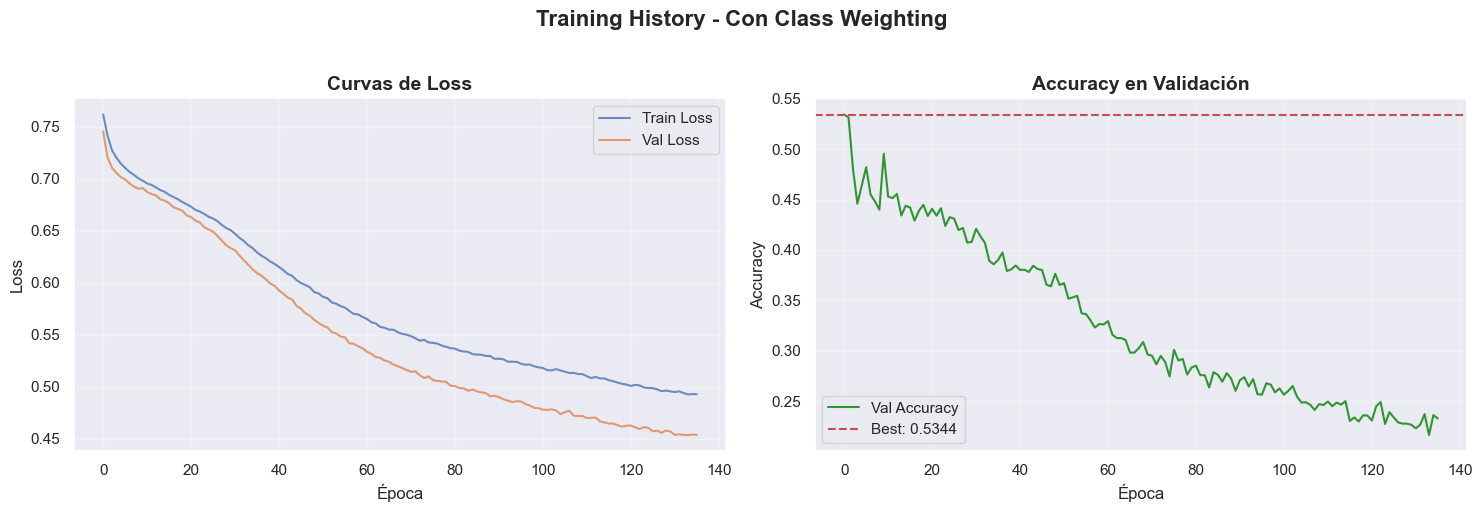

Tiempo de predicción: 0.1278 s
Tiempo total: 219.2905 s
MÉTRICAS - CON CLASS WEIGHTING
Accuracy: 0.7682 (76.8%)
F1-score: 0.4562

              precision    recall  f1-score   support

No Arrestado       0.94      0.78      0.85     43780
   Arrestado       0.34      0.71      0.46      6964

    accuracy                           0.77     50744
   macro avg       0.64      0.74      0.65     50744
weighted avg       0.86      0.77      0.80     50744


Desglose de la Matriz de Confusión:
  Verdaderos Negativos (TN): 34,052
  Falsos Positivos (FP):     9,728
  Falsos Negativos (FN):     2,032
  Verdaderos Positivos (TP): 4,932

Métricas derivadas:
  Precisión (Precision): 0.3364
  Recall (Sensibilidad): 0.7082
  Especificidad: 0.7778


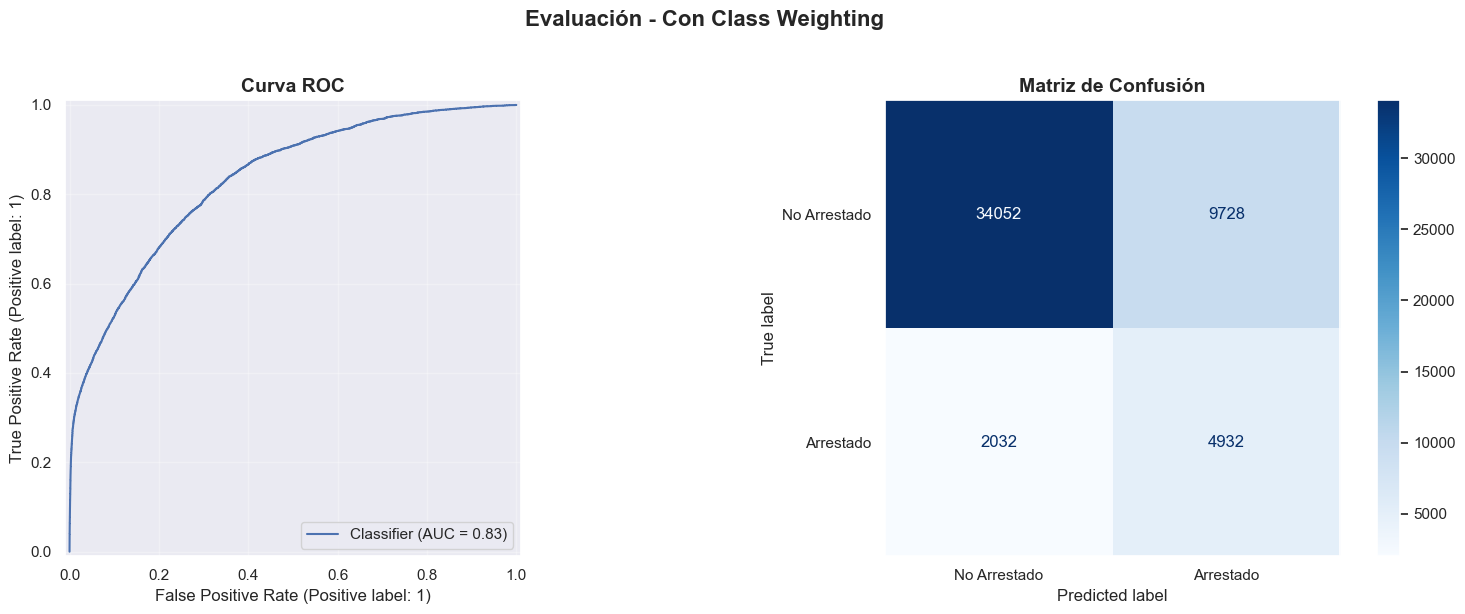

In [28]:
# Graficar curvas de entrenamiento del modelo weighted
plot_training_history(history_weighted, title="Training History - Con Class Weighting")

# Medir tiempo de predicción
start_predict_time_weighted = time.time()
predictions_weighted = evaluate_model(model_weighted, test_loader, y_test, use_sigmoid=False)
end_predict_time_weighted = time.time()
prediction_time_weighted = end_predict_time_weighted - start_predict_time_weighted

y_pred_weighted = predictions_weighted['y_pred']
y_pred_proba_weighted = predictions_weighted['y_pred_proba']

print(f"Tiempo de predicción: {prediction_time_weighted:.4f} s")
print(f"Tiempo total: {training_time_weighted + prediction_time_weighted:.4f} s")

# Imprimir métricas
print_metrics(y_test, y_pred_weighted, title="MÉTRICAS - CON CLASS WEIGHTING")

# Graficar ROC y Matriz de Confusión
cm_weighted = plot_evaluation_results(y_test, y_pred_weighted, y_pred_proba_weighted,
                                       title="Evaluación - Con Class Weighting")

In [29]:
metrics_dl_weighted = {
    'model_name': 'Deep Learning (Class Weighting)',
    'Accuracy': float(accuracy_score(y_test, y_pred_weighted)),
    'Precision': float(precision_score(y_test, y_pred_weighted, average='weighted')),
    'Recall': float(recall_score(y_test, y_pred_weighted, average='weighted')),
    'F1-Score': float(f1_score(y_test, y_pred_weighted, average='weighted')),
    'AUC': float(roc_auc_score(y_test, y_pred_proba_weighted)),
    'MCC score': float(matthews_corrcoef(y_test, y_pred_weighted)),
    'Entrenamiento (s)': float(training_time_weighted),
    'Predicción (s)': float(prediction_time_weighted),
    'Tiempo Total (s)': float(training_time_weighted + prediction_time_weighted)
}
save_model_metrics('Deep Learning Class Weighting', metrics_dl_weighted)

✓ Métricas guardadas en: ../datasets/deep_learning_class_weighting_metrics.json
